In [1]:
from asim.dataset.scene.scene_builder import ArrowSceneBuilder
from asim.dataset.scene.scene_filter import SceneFilter

In [2]:


from nuplan.planning.utils.multithreading.worker_sequential import Sequential
# from nuplan.planning.utils.multithreading.worker_ray import RayDistributed

In [3]:
import os, psutil

def print_memory_usage():
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    print(f"Memory usage: {memory_info.rss / 1024 ** 2:.2f} MB")


split = "nuplan_mini_val"

# log_names = ["2021.06.07.12.54.00_veh-35_01843_02314"]
scene_tokens = ["adb952e1bc2c55f3"]
log_names = None
# scene_tokens = None

scene_filter = SceneFilter(split_names=[split], log_names=log_names, scene_tokens=scene_tokens, duration_s=5.0)
scene_builder = ArrowSceneBuilder("/home/daniel/asim_workspace/data")
worker = Sequential()  
# worker = RayDistributed()
scenes = scene_builder.get_scenes(scene_filter, worker)

print(len(scenes))

for scene in scenes[:10]:
    print(scene.log_name, scene.token)


# _Rep0_longest1_route0_06_13_17_21_21 457da031d28ba67b
# _Rep0_longest1_route0_06_13_17_21_21 1f6d4a8c9a399b3b
# _Rep0_longest1_route0_06_13_17_21_21 5b7a3e90922db277
# _Rep0_longest1_route0_06_13_17_21_21 827d6ac2ff5356d0
# _Rep0_longest1_route0_06_13_17_21_21 16717aba72175425
# _Rep0_longest1_route0_06_13_17_21_21 5b7444f86f19b444
# _Rep0_longest1_route0_06_13_17_21_21 6ee6004b304f1d3c
# _Rep0_longest1_route0_06_13_17_21_21 c98966ed60a77f7e
# _Rep0_longest1_route0_06_13_17_21_21 790b09ca88553770
# _Rep0_longest1_route0_06_13_17_21_21 b6c1a8d385648623

1
2021.06.08.14.35.24_veh-26_02555_03004 adb952e1bc2c55f3


In [4]:
from pathlib import Path
from typing import Optional, Tuple

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from tqdm import tqdm

from asim.common.geometry.base import Point2D, StateSE2
from asim.common.geometry.bounding_box.bounding_box import BoundingBoxSE2
from asim.common.visualization.color.default import EGO_VEHICLE_CONFIG
from asim.common.visualization.matplotlib.observation import (
    add_bounding_box_to_ax,
    add_box_detections_to_ax,
    add_default_map_on_ax,
    add_traffic_lights_to_ax,
)
from asim.dataset.arrow.conversion import TrafficLightDetectionWrapper
from asim.dataset.maps.abstract_map import AbstractMap
from asim.dataset.recording.detection.detection import BoxDetectionWrapper
from asim.dataset.scene.abstract_scene import AbstractScene
from nuplan.common.actor_state.ego_state import EgoState
import io
from PIL import Image


def add_ego_vehicle_to_ax_(ax: plt.Axes, ego_state: EgoState) -> None:
    bounding_box = BoundingBoxSE2(
        center=StateSE2(*ego_state.center),
        length=ego_state.car_footprint.length,
        width=ego_state.car_footprint.width,
    )
    add_bounding_box_to_ax(ax, bounding_box, EGO_VEHICLE_CONFIG)


def _plot_scene_on_ax(
    ax: plt.Axes,
    map_api: AbstractMap,
    ego_state: EgoState,
    box_detections: BoxDetectionWrapper,
    traffic_light_detections: TrafficLightDetectionWrapper,
    radius: float = 80,
) -> plt.Axes:

    point_2d = Point2D(ego_state.center.x, ego_state.center.y)
    add_default_map_on_ax(ax, map_api, point_2d, radius=radius)
    add_traffic_lights_to_ax(ax, traffic_light_detections, map_api)

    add_box_detections_to_ax(ax, box_detections)
    add_ego_vehicle_to_ax_(ax, ego_state)

    ax.set_xlim(point_2d.x - radius, point_2d.x + radius)
    ax.set_ylim(point_2d.y - radius, point_2d.y + radius)


    ax.set_aspect("equal", adjustable="box")
    return ax

def plot_scene_to_image(
    map_api: AbstractMap,
    ego_state: EgoState,
    box_detections: BoxDetectionWrapper,
    traffic_light_detections: TrafficLightDetectionWrapper,
    radius: float = 80,
    figsize: Tuple[int, int] = (8, 8),
) -> Image:

    fig, ax = plt.subplots(figsize=figsize)
    _plot_scene_on_ax(ax, map_api, ego_state, box_detections, traffic_light_detections, radius)
    ax.set_aspect("equal", adjustable="box")
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    # plt.tight_layout()
    
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf)
    return img


In [5]:
from asim.dataset.arrow.conversion import DetectionType
from asim.simulation.gym.demo_gym_env import DemoGymEnv
from asim.simulation.observation.agents_observation import _filter_agents_by_type

import time

images = []
agent_rollouts = []
plot: bool = False
action = [1.0, 0.1]  # Placeholder action, replace with actual action logic
env = DemoGymEnv(scenes)

start = time.time()

map_api, ego_state, detection_observation, current_scene = env.reset()
cars, _ = _filter_agents_by_type(detection_observation.box_detections, detection_types=[DetectionType.VEHICLE])
agent_rollouts.append(BoxDetectionWrapper(cars))
if plot:
    images.append(
        plot_scene_to_image(
            map_api,
            ego_state,
            detection_observation.box_detections,
            detection_observation.traffic_light_detections,
        )
    )


for i in range(150):
    ego_state, detection_observation, end = env.step(action)
    cars, _ = _filter_agents_by_type(detection_observation.box_detections, detection_types=[DetectionType.VEHICLE])
    agent_rollouts.append(BoxDetectionWrapper(cars))
    if plot:
        images.append(
            plot_scene_to_image(
                map_api,
                ego_state,
                detection_observation.box_detections,
                detection_observation.traffic_light_detections,
            )
        )
    if end:
        print("End of scene reached.")
        break

print(time.time() - start)

End of scene reached.
0.14933538436889648


In [6]:
import numpy as np


def create_gif(images, output_path, duration=100):
    """
    Create a GIF from a list of PIL images.

    Args:
        images (list): List of PIL.Image objects.
        output_path (str): Path to save the GIF.
        duration (int): Duration between frames in milliseconds.
    """
    if images:
        print(len(images))
        images_p = [img.convert('P', palette=Image.ADAPTIVE) for img in images]
        images_p[0].save(
            output_path,
            save_all=True,
            append_images=images_p[1:],
            duration=duration,
            loop=0
        )

if plot:
    create_gif(images, f"{split}_{0}_{action}.gif", duration=15)

In [23]:
from typing import Dict, List, Tuple

from asim.simulation.metrics.interaction_based import _get_collision_feature
from asim.simulation.metrics.map_based import _get_offroad_feature
from asim.simulation.metrics.sim_agents import _get_log_agents_array, _get_rollout_agents_array
import numpy as np
import numpy.typing as npt

from asim.common.geometry.bounding_box.bounding_box_index import BoundingBoxSE2Index, BoundingBoxSE3Index
from asim.dataset.arrow.conversion import BoxDetection, DetectionType
from asim.dataset.scene.abstract_scene import AbstractScene
from asim.dataset.recording.detection.detection import BoxDetectionWrapper
from asim.simulation.metrics.histogram_metric import HistogramIntersectionMetric
from asim.simulation.metrics.kinematics import (
    _get_linear_acceleration_from_agents_array,
    _get_linear_speed_from_agents_array,
    _get_yaw_rate_from_agents_array,
    _get_yaw_acceleration_from_agents_array,
)


def get_sim_agents_metrics(scene: AbstractScene, agent_rollouts: List[BoxDetectionWrapper]) -> float:

    def get_agent_tokens(agent_rollout: List[BoxDetection]) -> List[str]:
        return [
            box_detection.metadata.track_token
            for box_detection in agent_rollout
            if box_detection.metadata.detection_type == DetectionType.VEHICLE
        ]

    def _get_time_s_from_scene(scene: AbstractScene) -> List[float]:
        initial_timepoint = scene.get_timepoint_at_iteration(0)
        constant = 0.1
        time_s: List[float] = []
        for iteration in range(scene.get_number_of_iterations()):
            timestep = scene.get_timepoint_at_iteration(iteration)
            time_delta = timestep - initial_timepoint
            time_s.append(time_delta.time_s + constant)
        return time_s

    initial_agent_tokens = get_agent_tokens(agent_rollouts[0])
    time_s = _get_time_s_from_scene(scene)

    speed_metric = HistogramIntersectionMetric(min_val=0.0, max_val=25.0, n_bins=10)
    log_agents_array, log_agents_mask = _get_log_agents_array(scene, initial_agent_tokens)
    agents_array, agents_mask = _get_rollout_agents_array(agent_rollouts, initial_agent_tokens)

    agents_speed = _get_linear_speed_from_agents_array(agents_array, log_agents_mask)
    agents_acceleration = _get_linear_acceleration_from_agents_array(agents_array, log_agents_mask)
    agents_yaw_rate = _get_yaw_rate_from_agents_array(agents_array, log_agents_mask)
    agents_yaw_acceleration = _get_yaw_acceleration_from_agents_array(agents_array, log_agents_mask)

    log_speed = _get_linear_speed_from_agents_array(log_agents_array, log_agents_mask)
    log_acceleration = _get_linear_acceleration_from_agents_array(log_agents_array, log_agents_mask)
    log_yaw_rate = _get_yaw_rate_from_agents_array(log_agents_array, log_agents_mask)
    log_yaw_acceleration = _get_yaw_acceleration_from_agents_array(log_agents_array, log_agents_mask)

    speed_metric = HistogramIntersectionMetric(min_val=0.0, max_val=25.0, n_bins=10)
    speed_result = speed_metric.calculate_intersection(agents_speed, log_speed, log_agents_mask)
    # speed_metric.plot_histograms(agents_speed, log_speed, log_agents_mask)

    acceleration_metric = HistogramIntersectionMetric(min_val=-12.0, max_val=12.0, n_bins=11)
    acceleration_result = acceleration_metric.calculate_intersection(
        agents_acceleration, log_acceleration, log_agents_mask
    )
    # acceleration_metric.plot_histograms(agents_acceleration, log_acceleration, log_agents_mask)

    yaw_rate_metric = HistogramIntersectionMetric(min_val=-0.628, max_val=0.628, n_bins=11)
    yaw_rate_result = yaw_rate_metric.calculate_intersection(agents_yaw_rate, log_yaw_rate, log_agents_mask)
    # yaw_rate_metric.plot_histograms(agents_yaw_rate, log_yaw_rate, log_agents_mask)

    yaw_acceleration_metric = HistogramIntersectionMetric(min_val=-3.14, max_val=3.14, n_bins=11)
    yaw_acceleration_result = yaw_acceleration_metric.calculate_intersection(
        agents_yaw_acceleration, log_yaw_acceleration, log_agents_mask
    )
    # yaw_acceleration_metric.plot_histograms(agents_yaw_rate, log_yaw_rate, log_agents_mask)

    return agents_array, log_agents_array, log_agents_mask, initial_agent_tokens


agents_array, log_agents_array, log_agents_mask, initial_agent_tokens = get_sim_agents_metrics(
    current_scene, agent_rollouts
)

collision = _get_collision_feature(agents_array, agent_rollouts)
collision.any(axis=1)


_offroad = _get_offroad_feature(agents_array, log_agents_mask, current_scene.map_api)
_offroad = _get_offroad_feature(log_agents_array, log_agents_mask, current_scene.map_api)



Offroad check took 0.03435 seconds
Offroad check took 0.03089 seconds


In [17]:
_offroad[-1].argmin()

np.int64(8)

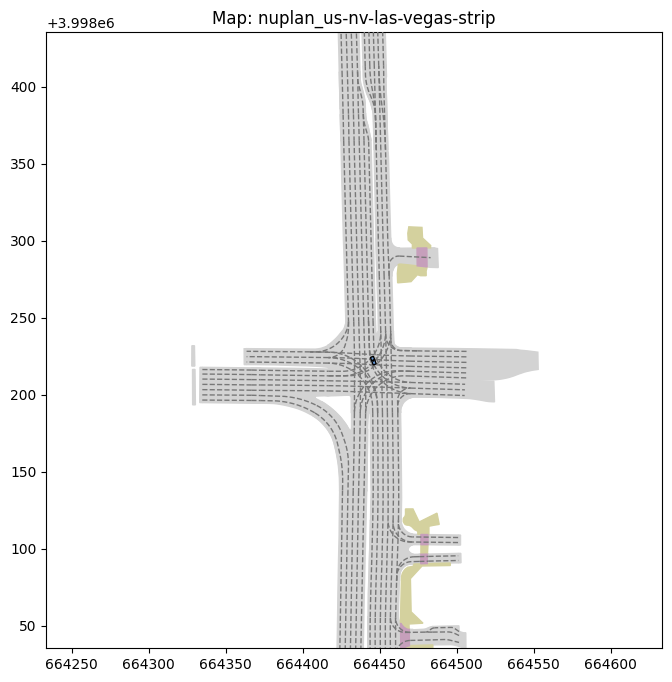

In [18]:


import shapely
import geopandas
from asim.dataset.maps.abstract_map import MapSurfaceType


def get_agent_tokens(agent_rollout: List[BoxDetection]) -> List[str]:
    return [
        box_detection
        for box_detection in agent_rollout
        if box_detection.metadata.detection_type == DetectionType.VEHICLE
    ]

def get_agent_by_id(agent_rollout: List[BoxDetection], token: str) -> List[str]:
    out = None
    for box_detection in agent_rollout:
        if box_detection.metadata.detection_type == DetectionType.VEHICLE and box_detection.metadata.track_token == token:
            out = box_detection
            break
    return out
# current_scene: AbstractScene 
map_api: AbstractMap = current_scene.map_api


radius = 200
fig, ax = plt.subplots(figsize=(8, 8))
ego_state = current_scene.get_ego_vehicle_state_at_iteration(0)
box_detections = current_scene.get_box_detections_at_iteration(0)


vehicle = get_agent_by_id(box_detections.box_detections, "ec5b68151b045a2e")


point_2d = Point2D(ego_state.bounding_box.center.x, ego_state.bounding_box.center.y)
add_default_map_on_ax(ax, map_api, point_2d, radius=radius)
add_box_detections_to_ax(ax, BoxDetectionWrapper([vehicle]))
ax.set_xlim(point_2d.x - radius, point_2d.x + radius)
ax.set_ylim(point_2d.y - radius, point_2d.y + radius)


ax.set_aspect("equal", adjustable="box")




# shapely_points = shapely.creation.points(vehicle.bounding_box_se2.corners_array)

# s2 = geopandas.GeoSeries(shapely_points)
# output = map_api._gpd_dataframes[MapSurfaceType.LANE_GROUP].sindex.query(shapely_points, predicate="within", sort=False, distance=None)


In [10]:
linear_speed[7], log_agents_mask[7]

NameError: name 'linear_speed' is not defined

In [ ]:
linear_speed[~log_agents_mask] = 0.0
linear_speed.max()


In [ ]:
gt_speed[7]

In [ ]:
from asim.simulation.metrics.histogram_metric import HistogramIntersectionMetric


speed_metric = HistogramIntersectionMetric(min_val=0.0, max_val=25.0, n_bins=10)

analysis = speed_metric.detailed_analysis(
    gt_speed,
    agent_speed
)

print(f"intersection: {analysis['intersection']:.4f}")
print(f"KL Divergence (1→2): {analysis['kl_divergence_1_to_2']:.4f}")
print(f"KL Divergence (2→1): {analysis['kl_divergence_2_to_1']:.4f}")
print(f"Bhattacharyya Distance: {analysis['bhattacharyya_distance']:.4f}")
print(f"Bhattacharyya Coeff: {analysis['bhattacharyya_coeff']:.4f}")

In [ ]:
speed_metric.plot_histograms(
    agent_speed,
    gt_speed,
)